https://lifetimes.readthedocs.io/en/latest/Quickstart.html
# Data
#### frequency
- number of repeat purchases the customer has made. 
- it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
#### T 
- Age of the customer in whatever time units chosen (weekly, in the above dataset). 
- This is equal to the duration between a customer’s first purchase and the end of the period under study.
#### recency 
- Age of the customer when they made their most recent purchases. 
- Duration between a customer’s first purchase and their latest purchase. 
- (Thus if they have made only 1 purchase, the recency is 0.)
#### monetary_value 
- The average value of a given customer’s purchases. 
- sum of all a customer’s purchases divided by the total number of purchases. 
- Note that the denominator here is different than the frequency described above.

In [1]:
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86



## BD/NBD Model in Customer Lifetime Value (CLV)
- BD/NBD model (short for Beta-Geometric/Negative Binomial Distribution) 
- probabilistic model used for predicting customer lifetime value (CLV) in non-contractual settings, where customers make purchases at irregular intervals and can "churn" (stop purchasing) at any time.
- This model helps answer:
    - How long will a customer remain active?
    - How many transactions will they make before churning?
    - What is the probability of a customer making a future purchase?
### Components of the BD/NBD Model
1. Purchase Process (NBD - Negative Binomial Distribution)
    - The number of purchases a customer makes over a given period follows a Poisson Process 
    - with individual heterogeneity modeled using a Gamma distribution.
    - This accounts for the fact that different customers have different purchase frequencies.
2. Dropout Process (BD - Beta-Geometric Distribution)
    - Each customer has a probability of churning after each purchase, which follows a Geometric process.
    - The heterogeneity in churn probability across customers is captured by a Beta distribution.
    
### How It Works
- Active Customers: Each customer is assumed to make repeat purchases at their own frequency.
- Churn Probability: After every purchase, there is a probability that the customer churns.
- Customer Heterogeneity: Some customers are naturally more frequent buyers, while others are likely to churn earlie
### Application in Customer Lifetime Value (CLV)
1. Estimating Future Purchases
    - The model predicts the expected number of purchases a customer will make in a given future period.
2. Churn Prediction
    - By estimating individual churn probability, businesses can identify which customers are likely to stop purchasing.
3. Customer Segmentation
    - Helps in segmenting customers based on their likelihood to make repeat purchases.
4. Revenue Forecasting
    - By combining predicted purchase frequency with average order value (AOV), businesses can estimate total future revenue per customer.
### Comparison with Other CLV Models
| --- | --- | --- |
| Model | Strengths | Weaknesses |
| --- | --- | --- |
| BD/NBD Model	 | Handles customer heterogeneity well; Accounts for dropout (churn) | Assumes purchase and dropout processes are independent |
| Pareto/NBD Model | More flexible than BD/NBD (allows customers to reactivate)	 | More complex to estimate |
| Gamma-Gamma Model	 | Predicts monetary value (spending per transaction) | Needs to be combined with a frequency model |

# Basic Frequency/Recency analysis using the BG/NBD model

In [2]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)
"""
<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>
"""

bgf.summary

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.242593,0.012557,0.217981,0.267205
alpha,4.413532,0.378221,3.672218,5.154846
a,0.792886,0.185719,0.428877,1.156895
b,2.425752,0.705345,1.043276,3.808229


## Visualizing our Frequency/Recency Matrix


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

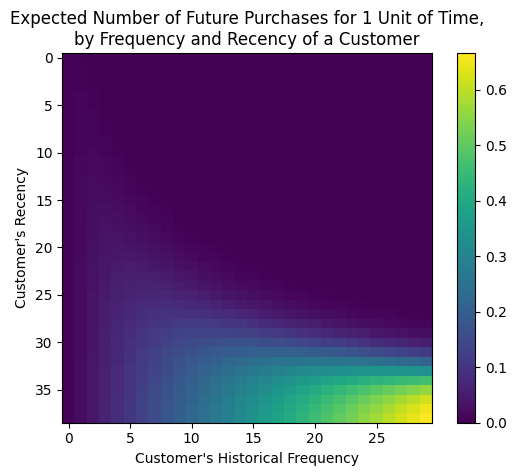

In [3]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)


# interesting matrix to look at is the probability of still being alive:

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

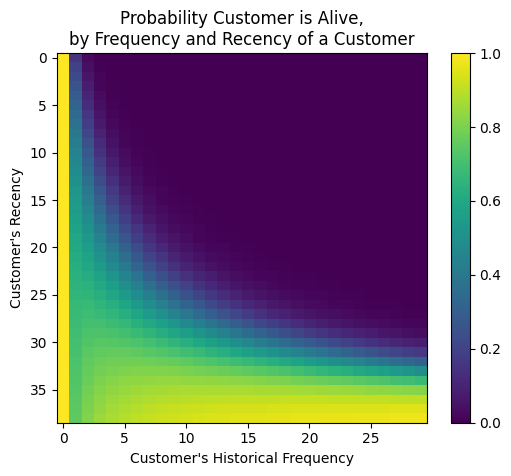

In [4]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

# Ranking customers from best to worst
- Return to our customers and rank them from “highest expected purchases in the next period” to lowest. 
- Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [5]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.424877
841,19,34.00,34.14,0.474738
1981,17,28.43,28.86,0.486526
157,29,37.71,38.00,0.662396
1516,26,30.86,31.00,0.710623


# Assessing model fit
- assess the model’s correctness. 
- The first is to compare your data versus artificial data simulated with your fitted model’s parameters.

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

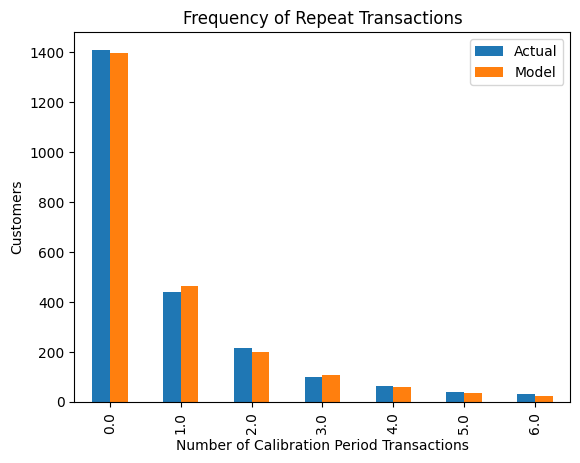

In [6]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

# Example using transactional datasets

In [7]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


In [8]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')

print(summary.head())

    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


In [9]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

## More model fitting

In [10]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )
print(summary_cal_holdout.head())

    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
id                                                                        
0             0.0          0.0  177.0                0.0             121.0
1             0.0          0.0  103.0                0.0             121.0
2             6.0        142.0  171.0                0.0             121.0
3             0.0          0.0   26.0                0.0             121.0
4             2.0          9.0   62.0                0.0             121.0


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

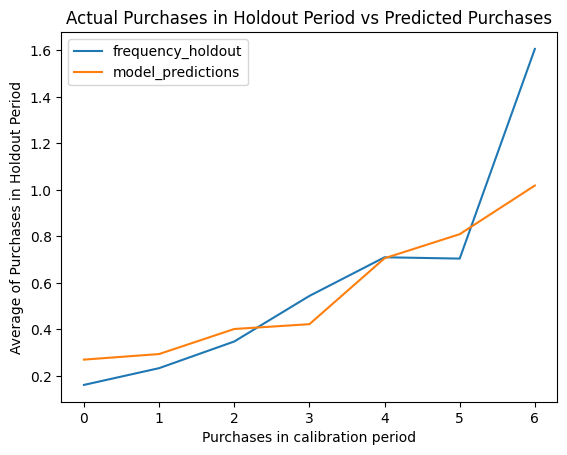

In [11]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

## Customer Predictions

In [12]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
# 0.0576511

np.float64(0.05765116591827101)

## Customer Probability Histories

ConversionError: Failed to convert value(s) to axis units: '2014-06-30 00:00:00'

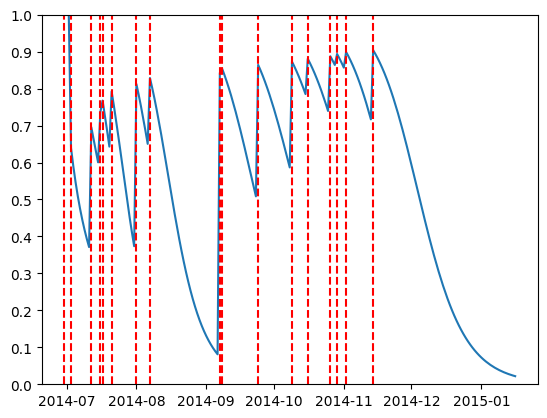

In [13]:
from lifetimes.plotting import plot_history_alive

id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

# Estimating customer lifetime value using the Gamma-Gamma model

In [14]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
6                    7    29.43  38.86           73.74
7                    1     5.00  38.86           11.77
9                    2    35.71  38.86           25.55


## The Gamma-Gamma model and the independence assumption

In [15]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


In [16]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


In [17]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

customer_id
1     24.658616
2     18.911480
3     35.171002
4     35.171002
5     35.171002
6     71.462851
7     18.911480
8     35.171002
9     27.282408
10    35.171002
dtype: float64


In [18]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 35.25295817605017, Average profit: 35.07855179704017


In [19]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

customer_id
1      140.096218
2       18.943466
3       38.180575
4       38.180575
5       38.180575
6     1003.868285
7       28.109681
8       38.180575
9      167.418224
10      38.180575
Name: clv, dtype: float64
